In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Global variables
BOARD_ROWS = 5 # Dimension of the grid in rows
BOARD_COLS = 5 # Dimension of the grid in colms
WIN_STATE = (4, 4) # destination
HOLES = [(1, 0), (1, 3), (3, 1), (4, 2)]  #holes with panelty and end state
START = (0, 0) # starting point
DEBUG = False  # Set to true to enable verbose output

In [3]:
# The code for enironment is taken from Week 9 provided by the professor. 
# The modification to the environment is done with the instruction given in the assignment. 
class State:
    def __init__(self, state=START):
        self.state = state
        self.isEnd = False

    def get_reward(self):
        if self.state == WIN_STATE:
            return 10.0
        elif self.state in HOLES:
            return -5.0
        else:
            return -1.0

    def is_end_func(self):
        if self.state == WIN_STATE or self.state in HOLES:
            self.isEnd = True

    def nxt_position(self, action):
        if action == 0:
            nxt_state = (self.state[0] - 1, self.state[1])  # Up
        elif action == 1:
            nxt_state = (self.state[0] + 1, self.state[1])  # Down
        elif action == 2:
            nxt_state = (self.state[0], self.state[1] - 1)  # Left
        else:
            nxt_state = (self.state[0], self.state[1] + 1)  # Right

        if 0 <= nxt_state[0] < BOARD_ROWS and 0 <= nxt_state[1] < BOARD_COLS:
            return nxt_state  # If next state legal
        return self.state  # Any move off the grid leaves state unchanged

In [4]:
def display_state(state):
    for i in range(BOARD_ROWS):
        print('---------------------')
        out = '| '
        for j in range(BOARD_COLS):
            if state == (i, j):
                token = '*'
            elif state == WIN_STATE:
                token = 'G'
            elif state in HOLES:
                token = 'H'
            else:
                token = '.'
            out += token + ' | '
        print(out)
    print('---------------------')

In [5]:
state = State()
display_state(state.state)

---------------------
| * | . | . | . | . | 
---------------------
| . | . | . | . | . | 
---------------------
| . | . | . | . | . | 
---------------------
| . | . | . | . | . | 
---------------------
| . | . | . | . | . | 
---------------------


In [6]:
# The Q learning algorithm is taken from week 9 notes of professor. 
class Agent:

    def __init__(self):
        self.states = []
        self.actions = [0, 1, 2, 3]  # up, down, left, right
        self.State = State()
        self.discount = 0.9
        self.lr = 0.5
        self.eps = 0.15

        # initialise state values
        self.action_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(len(self.actions)):
                    self.action_values[(i, j, k)] = 0.0  # set initial value to 0, for Q(s,a)

        self.new_action_values = []

    def choose_action(self, current_state):
        # choose action according to policy eps-greedy
        if np.random.uniform(0, 1) <= self.eps:
            action = np.random.choice(self.actions)
            if DEBUG:
                print("selecting random action")
        else:
            action = self.best_action(current_state)
        return action

    def take_action(self, action):
        position = self.State.nxt_position(action)
        self.State.state = position

    def best_action(self, state):
        best = -1
        max_val = -100000000
        for a in self.actions:
            q_val = self.action_values[state[0], state[1], a]
            if q_val >= max_val:
                max_val = q_val
                best = a
        return best

    def q_max(self, state):
        best = self.best_action(state)
        return self.action_values[state[0], state[1], best]

    def q_learning(self, episodes):
        rewards_per_episode = []
        for x in range(episodes):
            # Init S
            self.State.isEnd = False
            self.State.state = START  # Re init S Start state
            step = 0

            if DEBUG:
                print("**** Beginning episode", x, "****")
                self.show_values()

            total_reward = 0

            while True:  # repeat for each step of the episode (until S is terminal)

                # Store current state for Q update
                current_state = (self.State.state[0], self.State.state[1])

                # Choose action A from S using policy derived from Q (e-greedy)
                action = self.choose_action(current_state)

                # Take action A observe R and next State S'
                self.take_action(action)
                reward = self.State.get_reward()
                total_reward += reward
                self.State.is_end_func()
                next_state = self.State.state[0], self.State.state[1]

                # Update state action values
                old_q = self.action_values[current_state[0], current_state[1], action]
                max_q = self.q_max(next_state)
                new_q = old_q + self.lr * (reward + self.discount * max_q - old_q)
                self.action_values[current_state[0], current_state[1], action] = new_q

                step += 1
                if DEBUG:
                    print("step", step, "state", current_state, "action", action, "reward", reward,
                          "next_state", next_state, "old_q", old_q, "max_q", max_q, "new_q", new_q)

                # Check if s is terminal
                if self.State.isEnd:
                    break

                # S <- S' automatically when I took the action

            rewards_per_episode.append(total_reward)

        return rewards_per_episode

    def show_values(self):
        for i in range(0, BOARD_ROWS):
            print('----------------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                mx_nxt_value = -1000
                for a in self.actions:
                    nxt_value = self.action_values[(i, j, a)]
                    if nxt_value >= mx_nxt_value:
                        mx_nxt_value = nxt_value
                out += str(round(mx_nxt_value, 3)).ljust(6) + ' | '
            print(out)
        print('----------------------------------------')

In [7]:
def plot_learning_curve(rewards_per_episode, hyperparams):
    plt.plot(range(1, len(rewards_per_episode) + 1), rewards_per_episode)
    plt.title('Learning Curve: Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.savefig(f'learning_curve_{hyperparams}.png')
    plt.show()

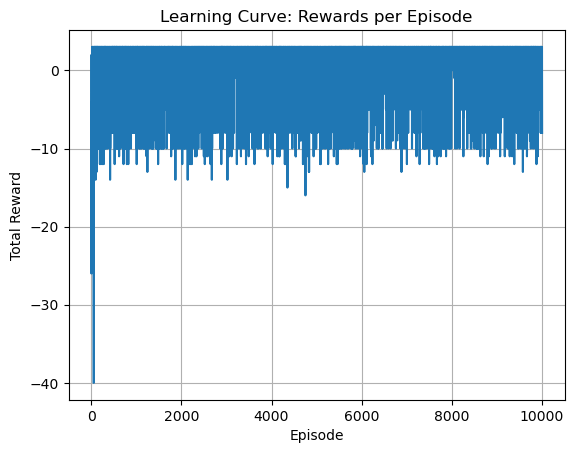

----------------------------------------
| -0.434 | 0.629  | 1.81   | 3.122  | 4.58   | 
----------------------------------------
| 0.0    | 1.81   | 3.122  | 0.0    | 6.2    | 
----------------------------------------
| 1.81   | 3.122  | 4.58   | 6.2    | 8.0    | 
----------------------------------------
| -2.577 | 0.0    | 6.2    | 8.0    | 10.0   | 
----------------------------------------
| -2.596 | -2.61  | 0.0    | 10.0   | 0.0    | 
----------------------------------------


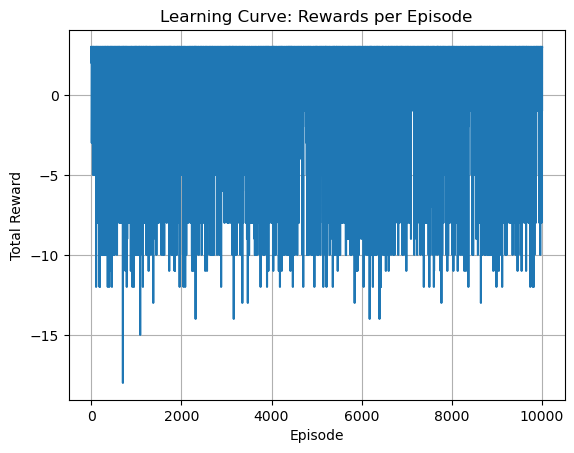

----------------------------------------
| -0.434 | 0.629  | 1.81   | 3.122  | 4.58   | 
----------------------------------------
| 0.0    | 1.81   | 3.122  | 0.0    | 6.2    | 
----------------------------------------
| 1.81   | 3.122  | 4.58   | 6.2    | 8.0    | 
----------------------------------------
| -2.577 | 0.0    | 6.2    | 8.0    | 10.0   | 
----------------------------------------
| -2.596 | -2.61  | 0.0    | 10.0   | 0.0    | 
----------------------------------------


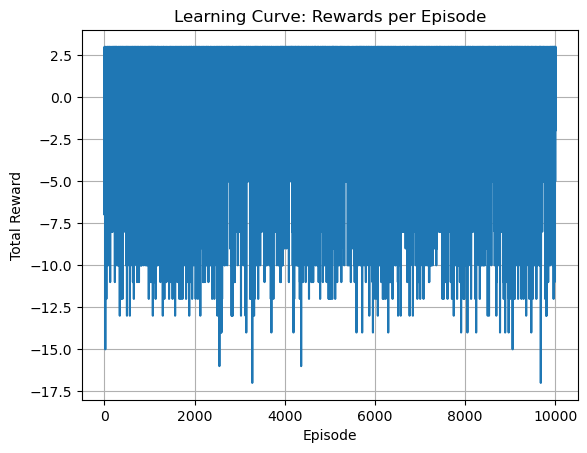

----------------------------------------
| -1.854 | -1.068 | -0.085 | 1.144  | 2.68   | 
----------------------------------------
| 0.0    | -0.085 | 1.144  | 0.0    | 4.6    | 
----------------------------------------
| -0.083 | 1.144  | 2.68   | 4.6    | 7.0    | 
----------------------------------------
| -2.577 | 0.0    | 4.6    | 7.0    | 10.0   | 
----------------------------------------
| -2.596 | -2.61  | 0.0    | 10.0   | 0.0    | 
----------------------------------------


In [8]:
#This is the main function in which we will try multiple senario for Learning Rate, Discount factor and explortion rate. 
# In the custom we will select which gives the best reward for 10000 episods. 
if __name__ == "__main__":
    ag = Agent()

    # Hyperparameters
    hyperparams = {
        'basic': {'alpha': 0.5, 'gamma': 0.9, 'epsilon': 0.10},
        'epsilon_decay': {'alpha': 0.5, 'gamma': 0.9, 'epsilon': 0.10},
        'custom': {'alpha': 0.7, 'gamma': 0.8, 'epsilon': 0.15}
        #'custom-2': {'alpha': 0.7, 'gamma': 0.8, 'epsilon': 0.15},
        #'custom-3': {'alpha': 0.6, 'gamma': 0.9, 'epsilon': 0.30}, #proving to be most optimal
        #'custom-4': {'alpha': 0.7, 'gamma': 0.99, 'epsilon': 0.10}
    }

    # Results storage
    results = {}

    # Run experiments for each set of hyperparameters
    for name, params in hyperparams.items():
        ag.lr = params['alpha']
        ag.discount = params['gamma']
        ag.eps = params['epsilon']
        rewards_per_episode = ag.q_learning(10000)
        results[name] = rewards_per_episode
        plot_learning_curve(rewards_per_episode, name)

        # Output maximum action value estimates for each state
        ag.show_values()

    # Output results to a file
    with open('results.txt', 'w') as f:
        for name, rewards_per_episode in results.items():
            f.write(f'{name} Hyperparameters:\n')
            f.write(f'Rewards per Episode: {rewards_per_episode}\n\n')

In [9]:
# Function to generate code for plotting line graph
def generate_line_graph(data, filename):
    plt.figure(figsize=(8, 6))
    for label, values in data.items():
        plt.plot(range(1, len(values) + 1), values, label=label)
    plt.title('Line Graph: Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()
    print(f"Line graph code saved in {filename}")

# Example data
cliffwalk_data = {'x': range(1, 10001), 'y': np.random.randn(10000).cumsum()}
line_graph_data = {'Basic': np.random.randn(10000).cumsum(),
                   'Epsilon Decay': np.random.randn(10000).cumsum(),
                   'Custom': np.random.randn(10000).cumsum()
                   #'Custom-2': np.random.randn(1000).cumsum(),
                   #'Custom-3': np.random.randn(1000).cumsum(),
                   #'Custom-4': np.random.randn(1000).cumsum()
                  }


# Generate code for line graph
generate_line_graph(line_graph_data, 'line_graph.png')

Line graph code saved in line_graph.png
